## 1. libraries import and setup

In [1]:
from pathlib import Path
import importlib.util
import rioxarray as rxr
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from matplotlib import pyplot as plt
import multiprocessing
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# load the setup.py module
path = Path.cwd().parent / 'src' / 'setup.py'
spec = importlib.util.spec_from_file_location('setup', path)
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

# call the make_folders function
raw_data_dir, processed_data_dir, output_dir = setup.make_folders()

created directory data\raw_data\nDSM
created directory data\raw_data\DOP
created directory data\raw_data\gaps_poly
created directory data\processed_data
created directory data\metadata
created directory output


## 2. data reading and preparation

In [3]:
# read preprocessed dataset (DOP for training with gap mask)
train_dataset = rxr.open_rasterio(processed_data_dir / 'dop_train_clipped_gapmask.tif',
                                  band_as_variable=True)

# use the long_names as variable names 
# (previously assigned in script 'data_preparation')
for var_name in train_dataset.data_vars:
    long_name = train_dataset[var_name].attrs['long_name']
    train_dataset = train_dataset.rename({var_name: long_name})

train_dataset

<xarray.Dataset>
Dimensions:      (x: 2916, y: 2086)
Coordinates:
  * x            (x) float64 5.464e+05 5.464e+05 5.464e+05 ... 5.47e+05 5.47e+05
  * y            (y) float64 5.73e+06 5.73e+06 5.73e+06 ... 5.73e+06 5.73e+06
    spatial_ref  int32 0
Data variables:
    red          (y, x) uint8 ...
    green        (y, x) uint8 ...
    blue         (y, x) uint8 ...
    nir          (y, x) uint8 ...
    gap_mask     (y, x) uint8 ...
Attributes:
    AREA_OR_POINT:  Area

A data generator is defined that tiles the given xr.Dataset into multiple tiles and returns them in batches (row-wise). It also splits the data into training, validation, and test data sets.

In [5]:
# define tile size
tilesize = 224

In [21]:
class CustomImageDataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, ds, sampletype, tilesize=tilesize):
        
        self.ds   = ds
        self.ylen = self.ds.y.size // tilesize
        self.xlen = self.ds.x.size // tilesize
        self.sampletype = sampletype
        
    def __len__(self):
        
        return self.ylen

    def __getitem__(self, index):
        
        red   = self.ds.red[index*tilesize:(index+1)*tilesize,:-(self.ds.x.size%tilesize)]
        green = self.ds.green[index*tilesize:(index+1)*tilesize,:-(self.ds.x.size%tilesize)]
        blue  = self.ds.blue[index*tilesize:(index+1)*tilesize,:-(self.ds.x.size%tilesize)]
        gaps  = self.ds.gap_mask[index*tilesize:(index+1)*tilesize,:-(self.ds.x.size%tilesize)]
        
        rgb   = np.array([red,green,blue]).transpose(1,2,0)
        gaps  = np.array(gaps)
        
        # split into tiles
        rgb_tiles    = np.array(np.split(rgb, self.xlen,axis=1))
        target_tiles = np.array(np.split(gaps, self.xlen,axis=1))
        
        # depending on sampletype, return training, validation or test set (complete set)
        if self.sampletype == 'training' or self.sampletype == 'validation':
            
            rgb_tiles_tr, rgb_tiles_val, target_tiles_tr, target_tiles_val = train_test_split(rgb_tiles, target_tiles, shuffle=True, test_size=0.2, random_state=11)
            
            if self.sampletype == 'training': 
                
                return rgb_tiles_tr, target_tiles_tr
        
            else:
                
                return rgb_tiles_val, target_tiles_val
        
        if self.sampletype == 'test': 
            
            return rgb_tiles, target_tiles
        
        return None

## 3. U-Net construction
U-Net network structure, first introduced by [Ronneberger et al. (2015)](https://arxiv.org/abs/1505.04597), is used. The encoder is modified by using ResNet50V2 ([He et al. (2016)](https://arxiv.org/abs/1603.05027)) architecture as pretrained model. 

In [7]:
# load pretrained ResNet50V2 model
base_model = tf.keras.applications.ResNet50V2(input_shape=[tilesize, tilesize, 3], include_top=False)
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [8]:
# modify downstack/encoder for ResNet50V2
# use the activations of these layers
layer_names = [
    'conv1_conv',               # Initial Convolution layer
    'conv2_block3_preact_relu', # 56x56
    'conv3_block4_preact_relu', # 28x28
    'conv4_block6_preact_relu', # 14x14
    'post_bn',                  # 7x7
]

layers = [base_model.get_layer(name).output for name in layer_names]

# create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

# make this part of the model fix (not trainable)
down_stack.trainable = False

# modify upstack/decoder for ResNet50V2
up_stack = [
    pix2pix.upsample(896, 3),  # 7x7   -> 14x14
    pix2pix.upsample(448, 3),  # 14x14 -> 28x28
    pix2pix.upsample(224, 3),  # 28x28 -> 56x56
    pix2pix.upsample(112, 3),  # 56x56 -> 112x112
]

In [11]:
# define modified U-Net
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[tilesize, tilesize, 3])
    x = inputs
    
    # downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # this is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [12]:
# compile the model with 2 output channels/classes
OUTPUT_CHANNELS = 2

model = unet_model(output_channels=OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#tf.keras.utils.plot_model(model, show_shapes=True)

In [22]:
# create an instance of the data generator
# hand over the training dataset (DOP with gap mask)
cidg_training   = CustomImageDataGenerator(train_dataset, sampletype="training")
cidg_validation = CustomImageDataGenerator(train_dataset, sampletype="validation")

In [14]:
# function to display exemplary data
def plotExample(dataGen, batch_id, tile_id):
    batch = dataGen.__getitem__(batch_id)
    predi = model.predict(batch[0])
    
    fig, ax = plt.subplots(1,3,figsize=(16,6))
    ax[0].imshow(batch[0][tile_id]); ax[0].set_title("RGB input")
    ax[1].imshow(batch[1][tile_id], cmap="Greys", interpolation="None"); ax[1].set_title("True mask")
    ax[2].imshow(np.argmax(predi[tile_id], axis=-1), cmap="Greys", interpolation="None"); ax[2].set_title("Prediction")
    plt.show()
    
    return

1/1 [==============================] - 1s 1s/step


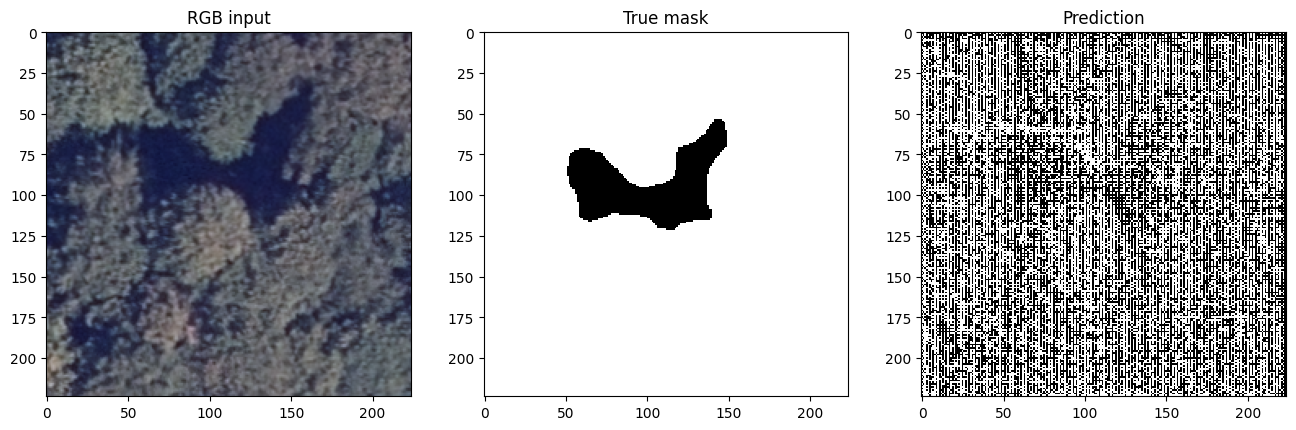

In [15]:
plotExample(cidg_training,5,3)

## 4. model training

In [40]:
# implement stop of training when validation loss
# has stopped improving for 15 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

In [41]:
model_history = model.fit(cidg_training,
                          validation_data=cidg_validation,
                          epochs=50,
                          initial_epoch=0,
                          callbacks=[early_stopping],
                          workers=multiprocessing.cpu_count() - 4)

Epoch 1/50
9/9 [==============================] - 17s 2s/step - loss: 0.1584 - accuracy: 0.9426 - val_loss: 0.2373 - val_accuracy: 0.9187
Epoch 2/50
9/9 [==============================] - 16s 2s/step - loss: 0.1864 - accuracy: 0.9346 - val_loss: 0.2987 - val_accuracy: 0.9127
Epoch 3/50
9/9 [==============================] - 16s 2s/step - loss: 0.1795 - accuracy: 0.9361 - val_loss: 0.3465 - val_accuracy: 0.9078
Epoch 4/50
9/9 [==============================] - 16s 2s/step - loss: 0.2126 - accuracy: 0.9341 - val_loss: 0.2850 - val_accuracy: 0.9140
Epoch 5/50
9/9 [==============================] - 16s 2s/step - loss: 0.1997 - accuracy: 0.9380 - val_loss: 0.2629 - val_accuracy: 0.9196
Epoch 6/50
9/9 [==============================] - 16s 2s/step - loss: 0.1680 - accuracy: 0.9435 - val_loss: 0.2585 - val_accuracy: 0.9208
Epoch 7/50
9/9 [==============================] - 16s 2s/step - loss: 0.2017 - accuracy: 0.9350 - val_loss: 0.2905 - val_accuracy: 0.9160
Epoch 8/50
9/9 [==================

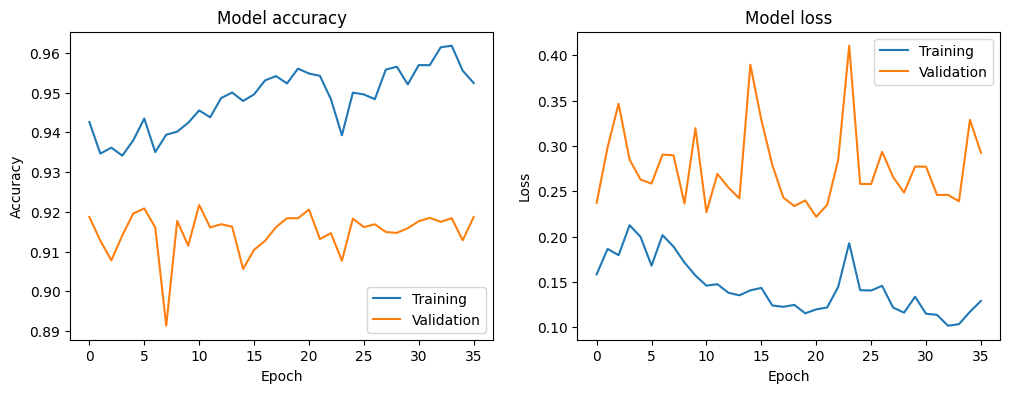

In [42]:
# plot accuracy and loss over the epochs
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(model_history.history['accuracy'])
ax[0].plot(model_history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Training', 'Validation'], loc='lower right')

ax[1].plot(model_history.history['loss'])
ax[1].plot(model_history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Training', 'Validation'], loc='upper right')

plt.show()

In [43]:
# print maximum validation accurarcy
max(model_history.history['val_accuracy'])

0.9216985702514648

In [44]:
# print minimum validation loss
min(model_history.history['val_loss'])

0.22186201810836792

1/1 [==============================] - 1s 832ms/step


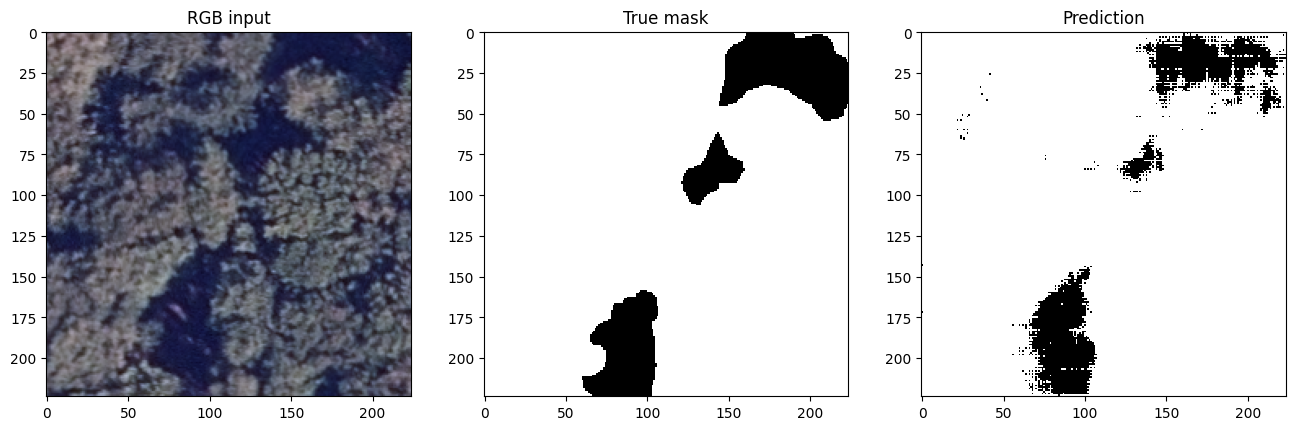

In [45]:
# plot example prediction after training
plotExample(cidg_training,5,3)

In [46]:
# save model
model.save(processed_data_dir / 'resnet50v2_unet')

INFO:tensorflow:Assets written to: P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\resnet50v2_unet\assets


INFO:tensorflow:Assets written to: P:\KfP\Aktiv\KfP_FE\canopy_gap_detection\gap_detection\data\processed_data\resnet50v2_unet\assets
